In [1]:
# n = [100,1000,10000,100000]
# PSNR = [28.49,31.35,33.50,34.18]
# plt.semilogx(n, PSNR)
# plt.show()
# ########## no need #########
# f_num = [16,24,32,48,64]
# PSNR = [33.98,32.61,31.35,29.35,27.84]
# plt.plot(f_num, PSNR)
# plt.show()

#### PSNR(pred, gt)

EDSR, on DIV2k train/val set, 10 epochs, 2e-4 learning rate
random crop 256x256 of train set images and val on 512 center crop.

| #\n_photon | 100   | 1000  | 10000 | 100000 |
|------------|-------|-------|-------|--------|
| 16         | 32.11 | 36.51 | 40.30 | 44.45  |
| 20         | 31.88 | 35.95 | 39.38 | 42.88  |
| 24         | 31.50 | 35.42 | 38.44 | 41.47  |

#### PSNR(input, gt)

| #\n_photon | 100   | 1000  | 10000 | 100000 |
|------------|-------|-------|-------|--------|
| 16         | 22.53 | 30.76 | 34.38 | 34.99  |
| 20         | 22.43 | 30.08 | 32.93 | 33.36  |
| 24         | 22.32 | 29.47 | 31.82 | 32.15  |

In [2]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import cv2

from models import SRCNN, EDSR
from utils import calc_psnr
from datasets import Camera
import glob

/home/qian/Documents/SRCNN-pytorch/datasets.py:66: RuntimeWarning: invalid value encountered in true_divide
  f = j1(rho)/rho


In [3]:
cudnn.benchmark = True
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = EDSR().to(device)

n_photon=100
f_num=24

state_dict = model.state_dict()
path = glob.glob('outputs/{}x{}/*.pth'.format(n_photon, f_num))
for n, p in torch.load(path[0], map_location=lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise KeyError(n)

model.eval()

image = cv2.imread('/media/qian/7f6908d4-b97f-4a1e-ba90-d502c5308801/DIV2K_valid_HR/0831.png', 0)
image = np.array(image).astype(np.float32)/255.
y = Camera(n_photon=n_photon,f_num=f_num).forward(image)
y_t = torch.from_numpy(y).float().to(device)
y_t = y_t.unsqueeze(0).unsqueeze(0)

image_t = torch.from_numpy(image).float().to(device).unsqueeze(0).unsqueeze(0)

with torch.no_grad():
    preds = model(y_t).clamp(0.0, 1.0)

preds = preds[0, 0].cpu().numpy()

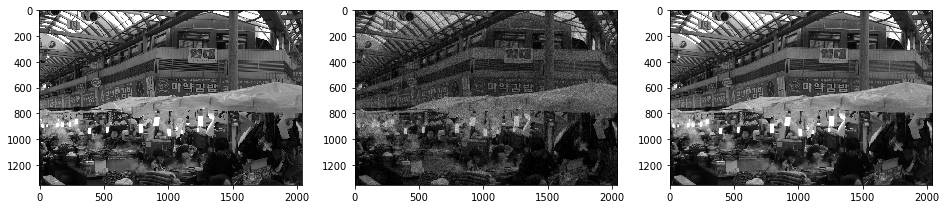

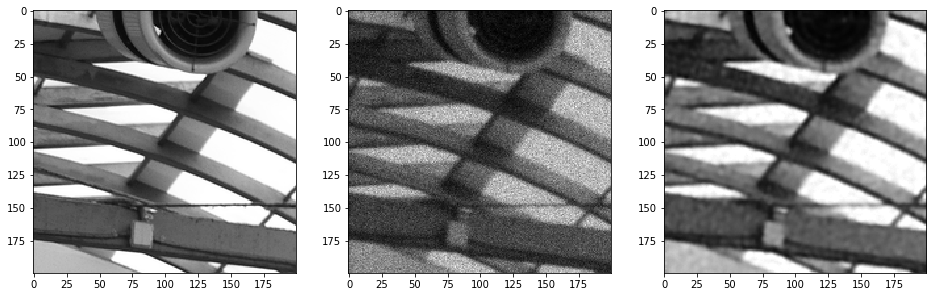

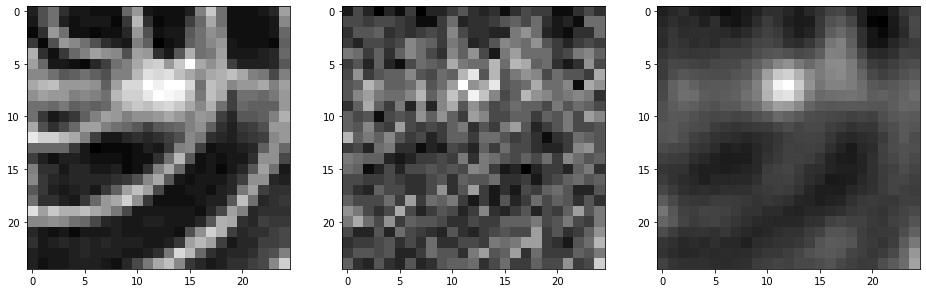

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image,cmap='gray')
ax[1].imshow(y,cmap='gray')
ax[2].imshow(preds,cmap='gray')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image[:200, :200],cmap='gray')
ax[1].imshow(y[:200, :200],cmap='gray')
ax[2].imshow(preds[:200, :200],cmap='gray')
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 10))
ax[0].imshow(image[:25, 125:150],cmap='gray')
ax[1].imshow(y[:25, 125:150],cmap='gray')
ax[2].imshow(preds[:25, 125:150],cmap='gray')
plt.show()